In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the enriched data
df = pd.read_csv('../data/processed/ethiopia_fi_enriched.csv')

# Load the matrix from Task 3
matrix_path = '../data/processed/event_indicator_matrix.csv'
if os.path.exists(matrix_path):
    impact_matrix = pd.read_csv(matrix_path, index_col=0)
else:
    # If file missing, we create a manual dictionary based on Task 3 logic
    print("⚠️ Matrix file not found. Using default magnitudes.")
    impact_matrix = pd.DataFrame()

# Targets defined by the consortium
target_access = 'ACC_OWNERSHIP'
target_usage = 'ACC_MM_ACCOUNT' 

forecast_years = [2025, 2026, 2027]

In [11]:
def get_trend_line(indicator_code):
    # Filter for observations (historical data points)
    subset = df[(df['indicator_code'] == indicator_code) & (df['record_type'] == 'observation')]
    
    # Extract years and values
    x = subset['year'].values
    y = subset['value_numeric'].values
    
    if len(x) < 2:
        return lambda year: y[0] if len(y) > 0 else 0
    
    # Calculate slope (m) and intercept (b)
    m, b = np.polyfit(x, y, 1)
    return lambda year: m * year + b

# Initialize baseline functions
baseline_access = get_trend_line(target_access)
baseline_usage = get_trend_line(target_usage)

print(f"✅ Baseline trends established for {target_access} and {target_usage}")

✅ Baseline trends established for ACC_OWNERSHIP and ACC_MM_ACCOUNT


In [12]:
# Magnitude weights (percentage points) derived from Task 3
event_weights = {
    'EVT_FAYDA': {'target': target_access, 'mag': 5.5},
    'EVT_MPESA': {'target': target_usage, 'mag': 4.0},
    'EVT_NFIS2': {'target': target_access, 'mag': 2.0}
}

def get_event_shock(year, target_code, scenario_mult):
    total_shock = 0
    # Ramp-up: 2025 (40%), 2026 (80%), 2027 (100%)
    ramp_up = {2025: 0.4, 2026: 0.8, 2027: 1.0}
    
    for evt, details in event_weights.items():
        if details['target'] == target_code:
            total_shock += (details['mag'] * ramp_up[year] * scenario_mult)
    return total_shock

In [13]:
scenarios = {'Optimistic': 1.2, 'Base': 1.0, 'Pessimistic': 0.7}
forecast_data = []

for year in forecast_years:
    for name, mult in scenarios.items():
        # Calculate Access
        acc_final = baseline_access(year) + get_event_shock(year, target_access, mult)
        # Calculate Usage
        usg_final = baseline_usage(year) + get_event_shock(year, target_usage, mult)
        
        forecast_data.append({
            'Year': year,
            'Scenario': name,
            'Access_Rate': round(acc_final, 2),
            'Usage_Rate': round(usg_final, 2)
        })

forecast_df = pd.DataFrame(forecast_data)
print("--- 2027 Financial Inclusion Projection ---")
print(forecast_df[forecast_df['Year'] == 2027])

--- 2027 Financial Inclusion Projection ---
   Year     Scenario  Access_Rate  Usage_Rate
6  2027   Optimistic        70.32        19.0
7  2027         Base        68.82        18.2
8  2027  Pessimistic        66.57        17.0


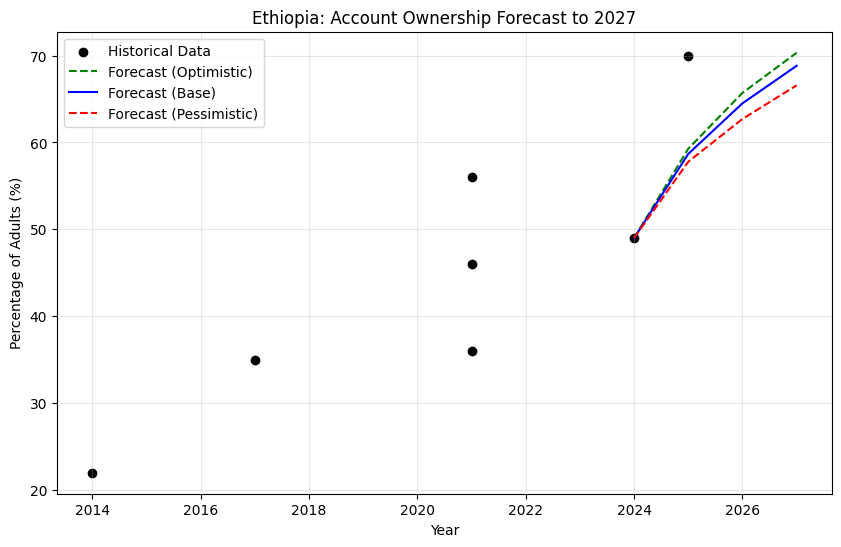

In [14]:
plt.figure(figsize=(10, 6))

# Plot historical points
hist_acc = df[df['indicator_code'] == target_access].sort_values('year')
plt.scatter(hist_acc['year'], hist_acc['value_numeric'], color='black', label='Historical Data')

# Plot Scenario Lines
colors = {'Optimistic': 'green', 'Base': 'blue', 'Pessimistic': 'red'}
for name, color in colors.items():
    subset = forecast_df[forecast_df['Scenario'] == name]
    # Connect 2024 to the forecast
    val_2024 = hist_acc[hist_acc['year'] == 2024]['value_numeric'].values[0]
    years = [2024] + list(subset['Year'])
    vals = [val_2024] + list(subset['Access_Rate'])
    plt.plot(years, vals, color=color, label=f'Forecast ({name})', linestyle='--' if name != 'Base' else '-')

plt.title("Ethiopia: Account Ownership Forecast to 2027")
plt.ylabel("Percentage of Adults (%)")
plt.xlabel("Year")
plt.legend()
plt.grid(alpha=0.3)
plt.show()